In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt

import shap
import seaborn as sns

In [92]:
data = pd.read_csv('data.csv')
data = pd.get_dummies(data,columns=["diagnosis"], drop_first=True).rename(columns={'diagnosis_M':'diagnosis'})
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

del data['id']

y = data.pop('diagnosis')
X = data
features = data.columns

### Pre-processing
First we want to check correlation between features so we can exclude some of them

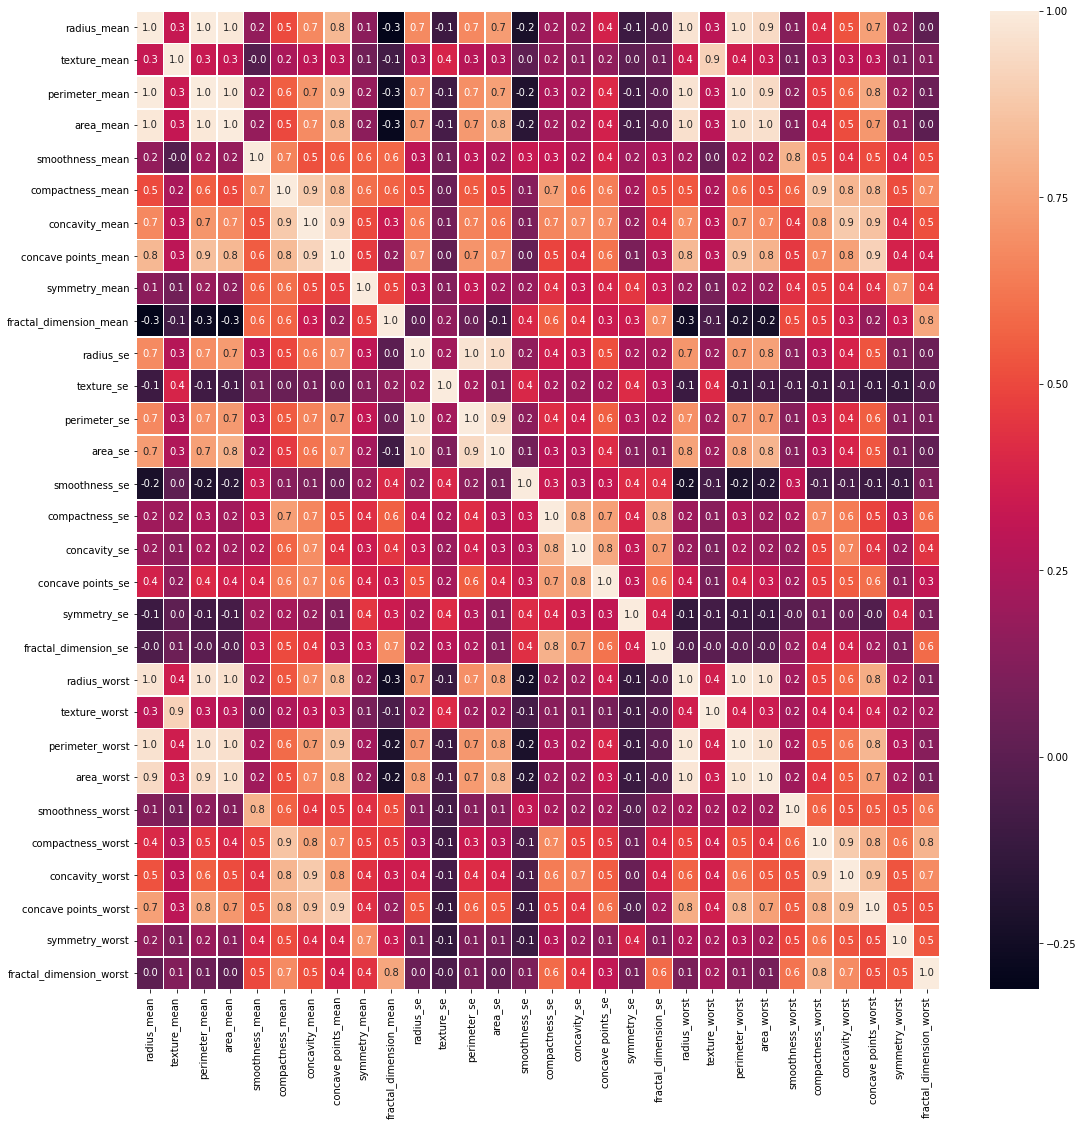

In [93]:
cor = X.corr()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cor, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

We will check which of the features correlate with threshold of 0.9

In [94]:
relevant_features = {}
features_to_keep = []
for target in X.columns:
    cor_target = abs(cor[target])
    #Selecting highly correlated features
    correlated_fatures = cor_target[cor_target > 0.9]
    correlated_fatures = correlated_fatures.drop(target)
    if len(correlated_fatures) > 0:
        relevant_features[target] = correlated_fatures
    else:
        features_to_keep.append(target)

In [6]:
for k, v in relevant_features.items():
    print(k, len(v))

radius_mean 5
texture_mean 1
perimeter_mean 5
area_mean 5
concavity_mean 1
concave points_mean 2
radius_se 2
perimeter_se 2
area_se 2
radius_worst 5
texture_worst 1
perimeter_worst 5
area_worst 5
concave points_worst 1


In [95]:
print(relevant_features['radius_mean'].index)
print(relevant_features['perimeter_mean'].index)
print(relevant_features['radius_worst'].index)
print(relevant_features['perimeter_worst'].index)
print(relevant_features['area_worst'].index)

Index(['perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst',
       'area_worst'],
      dtype='object')
Index(['radius_mean', 'area_mean', 'radius_worst', 'perimeter_worst',
       'area_worst'],
      dtype='object')
Index(['radius_mean', 'perimeter_mean', 'area_mean', 'perimeter_worst',
       'area_worst'],
      dtype='object')
Index(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst',
       'area_worst'],
      dtype='object')
Index(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst',
       'perimeter_worst'],
      dtype='object')


We can see that the 5 features depend on each other so we will choose randomly to keep only 'radius_mean'

In [96]:
features_to_keep.append('radius_mean')

In [97]:
print(relevant_features['texture_mean'].index)
print(relevant_features['texture_worst'].index)
print(relevant_features['radius_se'].index)
print(relevant_features['area_se'].index)
print(relevant_features['perimeter_se'].index)
print(relevant_features['concave points_worst'].index)
print(relevant_features['concave points_mean'].index)

Index(['texture_worst'], dtype='object')
Index(['texture_mean'], dtype='object')
Index(['perimeter_se', 'area_se'], dtype='object')
Index(['radius_se', 'perimeter_se'], dtype='object')
Index(['radius_se', 'area_se'], dtype='object')
Index(['concave points_mean'], dtype='object')
Index(['concavity_mean', 'concave points_worst'], dtype='object')


In the same way we keep 'texture_mean', 'radius_se' and 'cincave points_mean'

In [98]:
features_to_keep.append('texture_mean')
features_to_keep.append('radius_se')
features_to_keep.append('concave points_mean')

In [99]:
pd.DataFrame(features_to_keep)

,0
0,smoothness_mean
1,compactness_mean
2,symmetry_mean
3,fractal_dimension_mean
4,texture_se
5,smoothness_se
6,compactness_se
7,concavity_se
8,concave points_se
9,symmetry_se


In [184]:
X = X.loc[:, features_to_keep]
X.head()

,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,radius_mean,texture_mean,radius_se,concave points_mean
0,0.11840,0.27760,0.2419,0.07871,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890,17.99,10.38,1.0950,0.14710
1,0.08474,0.07864,0.1812,0.05667,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902,20.57,17.77,0.5435,0.07017
2,0.10960,0.15990,0.2069,0.05999,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758,19.69,21.25,0.7456,0.12790
3,0.14250,0.28390,0.2597,0.09744,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.6638,0.17300,11.42,20.38,0.4956,0.10520
4,0.10030,0.13280,0.1809,0.05883,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.2364,0.07678,20.29,14.34,0.7572,0.10430


Train-Test split

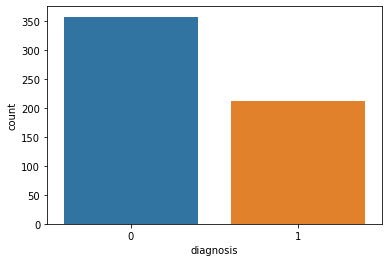

In [15]:
ax = sns.countplot(y,label="Count")

We want the ratio to be kept in the split so we will stratify by y

In [100]:
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y)
print('train size: {}'.format(train_x.shape))
print('test size: {}'.format(test_x.shape))



train size: (426, 20)
test size: (143, 20)


### Normalization of the data

In [ ]:
train_x = (train_x - train_x.mean()) / (train_x.max() - train_x.min())
test_x = (test_x - test_x.mean()) / (test_x.max() - test_x.min())

## Question 1
Find optimal parameters for number of estimators and maximum depth of the trees

In [ ]:
def get_best_params(stratifiedKfold):
    rfc = RandomForestClassifier()

    grid_params = {
        'n_estimators': [x for x in range(1, 1000) if x % 100 == 0],
        'max_depth': [x for x in range(1, 1000) if x % 50 == 0]
    }

    clfs = GridSearchCV(rfc, grid_params, scoring='roc_auc', return_train_score=True, cv=stratifiedKfold)
    clfs.fit(train_x, train_y)

    best_params = clfs.best_params_
    print(best_params)
    
    return clfs

In [34]:
stKFold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

classifiers = get_best_params(stKFold)
pd.DataFrame(list(zip(classifiers.cv_results_['params'], 
                      classifiers.cv_results_['mean_train_score'], 
                      classifiers.cv_results_['mean_test_score'])),
            columns = ["Parameter", "mean train score", "mean validation score"])

{'max_depth': 450, 'n_estimators': 300}


,Parameter,mean train score,mean validation score
0,"{'max_depth': 50, 'n_estimators': 100}",1.0,0.987824
1,"{'max_depth': 50, 'n_estimators': 200}",1.0,0.986741
2,"{'max_depth': 50, 'n_estimators': 300}",1.0,0.987817
3,"{'max_depth': 50, 'n_estimators': 400}",1.0,0.986285
4,"{'max_depth': 50, 'n_estimators': 500}",1.0,0.987514
...,...,...,...
166,"{'max_depth': 950, 'n_estimators': 500}",1.0,0.986927
167,"{'max_depth': 950, 'n_estimators': 600}",1.0,0.987345
168,"{'max_depth': 950, 'n_estimators': 700}",1.0,0.987048
169,"{'max_depth': 950, 'n_estimators': 800}",1.0,0.986933


## Qustion 2
We will check if the parameters we figured in Q1 are the only optimal parameters.<br>
We will use different number of folds and different random state.

In [37]:
stKFold = StratifiedKFold(n_splits=7, random_state=2, shuffle=True)

classifiers = get_best_params(stKFold)
pd.DataFrame(list(zip(classifiers.cv_results_['params'], 
                      classifiers.cv_results_['mean_train_score'], 
                      classifiers.cv_results_['mean_test_score'])),
            columns = ["Parameter", "mean train score", "mean validation score"])

{'max_depth': 600, 'n_estimators': 200}


,Parameter,mean train score,mean validation score
0,"{'max_depth': 50, 'n_estimators': 100}",1.0,0.986977
1,"{'max_depth': 50, 'n_estimators': 200}",1.0,0.988135
2,"{'max_depth': 50, 'n_estimators': 300}",1.0,0.986989
3,"{'max_depth': 50, 'n_estimators': 400}",1.0,0.987974
4,"{'max_depth': 50, 'n_estimators': 500}",1.0,0.988297
...,...,...,...
166,"{'max_depth': 950, 'n_estimators': 500}",1.0,0.988308
167,"{'max_depth': 950, 'n_estimators': 600}",1.0,0.988793
168,"{'max_depth': 950, 'n_estimators': 700}",1.0,0.988966
169,"{'max_depth': 950, 'n_estimators': 800}",1.0,0.988056


We can see that the best parameters are very different thats thank to the randomness in the creation of the forest.
For deterministic results we will use one the origin train-test split and use the same random state.

## Question 3
We will calculate the 5 most important features for random forest with the parameters we got in Q2

conclusions for Q3-Q5 in the end of Q6

In [185]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=600, random_state=0)
rfc.fit(train_x, train_y)
importance = rfc.feature_importances_

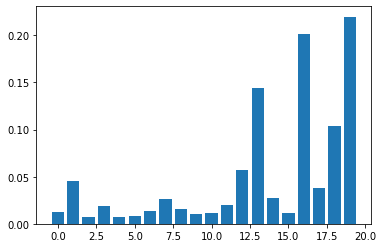

In [140]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### The 5 most important features are:

In [163]:
idx = np.argpartition(importance, -5)[-5:]
idx = idx[::-1]
imp_params = X.columns[idx]
pd.DataFrame(imp_params)

,0
0,concave points_mean
1,radius_mean
2,concavity_worst
3,radius_se
4,compactness_worst


## Question 4
We shall check with shap what are the 5 most important features.<br>
The check will be on data the model didn't see yet (i.e - the test set)

In [142]:
explainer = shap.KernelExplainer(rfc.predict_proba, shap.kmeans(train_x, 10))
kernel_shap_values = explainer.shap_values(test_x, l1_reg='num_features(10)')

In [164]:
kernel_mean_shap_values = np.abs(kernel_shap_values[0]).mean(axis=0)
idx = np.argpartition(kernel_mean_shap_values, -5)[-5:]
idx = idx[::-1]
imp_params = X.columns[idx]
pd.DataFrame(imp_params)

,0
0,radius_mean
1,concave points_mean
2,radius_se
3,concavity_worst
4,texture_mean


## Question 5

In [108]:
tree_explainer = shap.TreeExplainer(rfc, data=train_x)
tree_shap_values = tree_explainer.shap_values(X=test_x, y=test_y, check_additivity=False)

 94%|=================== | 270/286 [00:16<00:00]       

In [165]:
tree_mean_shap_values = np.abs(tree_shap_values[0]).mean(axis=0)
idx = np.argpartition(tree_mean_shap_values, -5)[-5:]
idx = idx[::-1]
imp_params = X.columns[idx]
pd.DataFrame(imp_params)

,0
0,concave points_mean
1,radius_mean
2,concavity_worst
3,radius_se
4,texture_mean


## Question 6
We will plot the 2 graphs and compare between the shap values of kernel and tree explainers

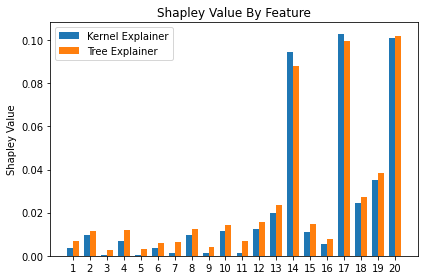

In [166]:
x = np.arange(len(X.columns))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.abs(kernel_mean_shap_values), width, label='Kernel Explainer')
rects2 = ax.bar(x + width/2, np.abs(tree_mean_shap_values), width, label='Tree Explainer')

ax.set_ylabel('Shapley Value')
ax.set_title('Shapley Value By Feature')
ax.set_xticks(x)
ax.set_xticklabels(x+1)
ax.legend()

fig.tight_layout()

plt.show()

### Conclusion Q3 - Q5
We can see both explainers get very close results and by most agrre about the importance of the features.
As for the difference between the most important feature between the explainers we can explain by the fact that the heatmap indicates that 'concave points_mean' and 'radius_mean' are corelated by 0.8 which is high (even though not enough to exclude one of them from the model).

The 'feature importance' explainer chooses the importance by most occurences in trees in the random forest.<br>
this depend on the random feature choosing and apparently makes the difference in the results from the shap explainers.

## Question 7
We can see that the tree explainer has better results in more features and we should use it, but the highest value is in the kernel explainer so we will use its best feature.<br>
Therefore, we will look for the example with the most influence by 'radius_mean'

We see that 

The index of 'radius_mean' is 16.
The 13th example has the highest 'radius_mean' value.

In [199]:
np.argmax(tree_shap_values[0][16])

13

In [168]:
shap.initjs()
shap.force_plot(tree_explainer.expected_value[0], tree_shap_values[0][13], feature_names=features_to_keep)

We observe that the most important feature is indeed 'radius_mean' which makes sense because we look at the most important example of the most important feature.

## Question 8
We will do the same as in Q7 but now we look for the example with the least influence by 'radius_mean'.

The index of the example is 9

In [200]:
np.argmin(tree_shap_values[0][16])

9

In [171]:
shap.force_plot(tree_explainer.expected_value[0], tree_shap_values[0][9], feature_names=features_to_keep)

We observe that the most important feature for this example is yet 'radius_mean'<br>
which shows us that even when the feature is not much important it is still the most important feature for this specific example.<br>
With further research, we may conclude that 'radius_mean' can be used as a classifier for appearance of malignant tumor.

In [183]:
X_radius = X.loc[:, 'radius_mean']
radius_rfc = RandomForestClassifier()
radius_rfc.fit(train_x, train_y)
radius_rfc.score(test_x, test_y)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


0.9370629370629371

As suspected, the 'radius_mean' classifier predicts with great accuracy the type of tumor.